**import packages**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
from IPython import display as ipythondisplay
import numpy as np
import random

np.random.seed(1234)
random.seed(1234)
tf.random.set_seed(1234)

**GMLVQ with transfer learning**

In [ ]:
class GMLVQ(tf.keras.layers.Layer):
  def __init__(self,feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer=''):
    super(GMLVQ, self).__init__()
    self.no_of_wts_per_class=no_of_wts_per_class;
    self.feat_dim=feat_dim;
    self.num_classes=num_classes;
    self.do_transfer=do_transfer;
    if(do_transfer==0):
      if(winit is None):
        self.w = self.add_weight("w",shape=[no_of_wts_per_class*num_classes,feat_dim])
      else:
        self.w =tf.Variable(winit,trainable=True)
      if(type_transfer=='LFT-TDS'):
        self.H =tf.constant(np.eye(feat_dim))
      else:
        self.G=tf.constant(np.eye(feat_dim))
        self.g=tf.constant(np.zeros(feat_dim))

    else:
      self.w1 = tf.constant(winit)
      if(type_transfer=='LFT-TDS'):
        self.H =tf.Variable(np.eye(feat_dim).astype('float32')[np.newaxis,:,:],trainable=True)
      else:
        self.G=tf.Variable(np.eye(feat_dim).astype('float32')[:,:],trainable=True)
        self.g=tf.Variable(np.zeros(feat_dim).astype('float32')[np.newaxis,:],trainable=True)

    self.type_transfer=type_transfer
    self.a=10; 
    self.class_labels=np.repeat(np.arange(num_classes),no_of_wts_per_class);
    self.class_labels=np.reshape(self.class_labels,-1)

  def ComputeAllDistance(self,x,y):  #v_i and class labels
    if(self.do_transfer==1):
      if(self.type_transfer=='LFT-TDS'):
        self.w=self.w1
        x=tf.matmul(self.H,tf.expand_dims(x,axis=-1))[:,:,0]
      else:
        #print(self.w.shape,self.G.shape,self.g.shape)
        self.w=tf.matmul(self.w1,self.G)+self.g
    diff=x-self.w 
    all_dist=[]
    min_val_pos=np.inf;
    max_val_neg=np.inf;
    pos_index = 0;
    #print(self.num_classes*self.no_of_wts_per_class)
    for j in range(self.num_classes*self.no_of_wts_per_class):
      #print(diff[j,:])
      dist=tf.reduce_sum(tf.expand_dims(diff[j,:],axis=0)**2)
      if(not np.isfinite(dist)):
        print('infinite/nan distance, data might need normalization')
     # print(dist)
      if(self.class_labels[j]==y):
        if(dist<=min_val_pos):
          min_val_pos=dist
          pos_index=j
      else:
        if(dist<=max_val_neg):
          max_val_neg=dist
          neg_index=j
      
      all_dist.append(dist)
   # print(dist)
    return all_dist[pos_index],all_dist[neg_index],pos_index

  def call(self, x,y):  #x--> (batch_size,fdim) # Lets work with batch size 1 ..!
    d_p,d_n,_=self.ComputeAllDistance(x,y)
    mu=(d_p-d_n)/(d_p+d_n)
    return tf.sigmoid(self.a*mu)

  def PointPredict(self,x):
    if(self.do_transfer==1):
      if(self.type_transfer=='LFT-TDS'):
        x=tf.matmul(self.H,tf.expand_dims(x,axis=-1))[:,:,0]
      else:
        self.w=tf.matmul(self.w,self.G)+self.g
    diff=x-self.w
    #print(diff)
    min_val_pos=np.inf;
    pos_index = 0;
    for j in range(self.num_classes*self.no_of_wts_per_class):
      dist=tf.reduce_sum(tf.expand_dims(diff[j,:],axis=0)**2)
      if(not np.isfinite(dist)):
        print('infinite/nan distance, data might need normalization')

      if(dist<min_val_pos):
          min_val_pos=dist
          pos_index=j
    #print(dist)
    return self.class_labels[pos_index]
    

    

**GTLVQ with transfer learning**

In [ ]:
class Orthonormality(tf.keras.constraints.Constraint):
  """Constrains weight tensors to be centered around `ref_value`."""
  def __init__(self,refval):
      pass;

  def __call__(self, w):
    #w=tfp.math.gram_schmidt(w);
    return w
  def get_config(self):
    return 0

class MatInit(tf.keras.initializers.Initializer):
  def __init__(self, Winit):
    self.Winit =Winit

  def __call__(self, shape, dtype=None):
    return Winit



class GLTVQ(tf.keras.layers.Layer):
  def __init__(self, feat_dim,r,no_of_wts_per_class,num_classes,winit=None,Winit=None):
    super(GLTVQ, self).__init__()
    self.no_of_wts_per_class=no_of_wts_per_class;
    self.feat_dim=feat_dim;
    self.num_classes=num_classes;
    if(winit is None):
      self.w = self.add_weight("w",shape=[no_of_wts_per_class*num_classes,feat_dim])
    else:
      self.w =tf.Variable(winit,trainable=True)

    if(Winit is None):
      self.W = self.add_weight("W",shape=[no_of_wts_per_class*num_classes,feat_dim,r],initializer='Orthogonal')  ## Orthonormality is required.
    else:
      weight_initilizer=MatInit(Winit)
      self.W = self.add_weight("W",shape=[no_of_wts_per_class*num_classes,feat_dim,r],initializer=weight_initilizer)
      #
      #self.W =tf.Variable(initial_value=Winit,trainable=True,constraint=Orthonormality)

    self.a=10; 
    self.r=r;  
    self.class_labels=np.repeat(np.arange(num_classes),no_of_wts_per_class);
    self.class_labels=np.reshape(self.class_labels,-1)

  def ComputeAllDistance(self,x,y):  #v_i and class labels
    diff=x-self.w
    all_dist=[]
    min_val_pos=np.inf;
    max_val_neg=np.inf;
    pos_index =0;
    neg_index = 0;
    for j in range(self.num_classes*self.no_of_wts_per_class):
      H=tf.matmul(self.W[j,:,:],self.W[j,:,:],transpose_b=True)
      #print(H.shape,diff[j,:].shape)
      dist=tf.reduce_sum(tf.matmul(H,tf.expand_dims(diff[j,:],axis=0),transpose_b=True)**2)
      if(self.class_labels[j]==y):
        if(dist<min_val_pos):
          min_val_pos=dist
          pos_index=j
      else:
        if(dist<max_val_neg):
          max_val_neg=dist
          neg_index=j
      
      all_dist.append(dist)
    return all_dist[pos_index],all_dist[neg_index],pos_index

  def call(self, x,y):  #x--> (batch_size,fdim) # Lets work with batch size 1 ..!
    d_p,d_n,_=self.ComputeAllDistance(x,y)
    mu=(d_p-d_n)/(d_p+d_n)
    return tf.sigmoid(self.a*mu)

  def PointPredict(self,x):
      diff=x-self.w
      min_val_pos=np.inf;
      pos_index =0;
      for j in range(self.num_classes*self.no_of_wts_per_class):
        H=tf.matmul(self.W[j,:,:],self.W[j,:,:],transpose_b=True)
        dist=tf.reduce_sum(tf.matmul(H,tf.expand_dims(diff[j,:],axis=0),transpose_b=True)**2)
        if(dist<min_val_pos):
            min_val_pos=dist
            pos_index=j
      return self.class_labels[pos_index]
  def Orthonormalize(self):
    self.W=tfp.math.gram_schmidt(self.W);
    

**Getting MNIST data using keras and tensorflow**

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print(x_train.shape,y_train.shape)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

x_train=tf.reshape(x_train,(x_train.shape[0],-1,1))
x_test=tf.reshape(x_test,(x_test.shape[0],-1,1))
print(x_train.shape,x_test.shape)
sel_inds=np.random.randint(60000,size=(20000));  ## Select 2000 train images at random 
X=x_train.numpy()[sel_inds,:]
labels=y_train[sel_inds]

sel_inds=np.random.randint(10000,size=(2000));  ## Select 500 test images at random 
x_test=x_test.numpy()[sel_inds,:]
y_test=y_test[sel_inds]
r=7;
nclasses=10

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1) (60000,)
Number of original training examples: 60000
Number of original test examples: 10000
(60000, 784, 1) (10000, 784, 1)


**Generate synthetic data**

(600, 2)


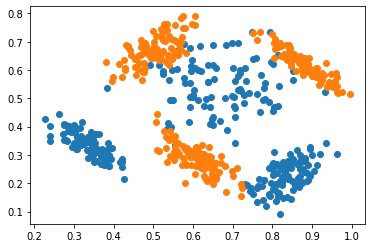

(600, 2)


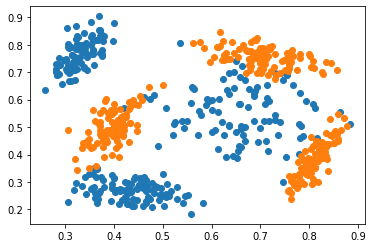

In [ ]:
from numpy.random import multivariate_normal
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split

nmixes=6;
npoints_perclass=100;
mu=np.array([[6,5],[4.5,6],[3,3],[7.5,2],[5.5,2.5],[8,5.5]])
label2lab={0:0,2:0,3:0,1:1,4:1,5:1}

var=[0.8*np.eye(2),np.array([[0.2,0.1],[0.1,0.2]]),np.array([[0.2,-0.15],[-0.15,0.2]]),np.array([[0.2,0.1],[0.1,0.2]]),np.array([[0.2,-0.15],[-0.15,0.2]]),np.array([[0.2,-0.18],[-0.18,0.2]])];
labels=[];

X=multivariate_normal(mu[0,:],var[0],size=(npoints_perclass))
labels.append(label2lab[0]*np.ones(npoints_perclass))

for m in range(1,nmixes):
  x=multivariate_normal(mu[m,:],var[m],size=(npoints_perclass))
  X=np.concatenate((X,x),axis=0);
  labels.append(label2lab[m]*np.ones(npoints_perclass))

X=X/9.0 ##--> reduce the scale 
labels=np.array(labels).reshape(-1)
print(X.shape)
for j in range(nmixes):
  plt.scatter(X[labels==j,0],X[labels==j,1])
plt.show()


X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.33, random_state=42)

## tansform data
theta=294*np.pi/180.0
R=np.array([[np.cos(theta),np.sin(theta)],[-np.sin(theta),np.cos(theta)]])
t=np.array([6,5])[np.newaxis,:]/9.0

Xtransform=np.dot(X-t,R)+t
print(Xtransform.shape)
for j in range(nmixes):
  plt.scatter(Xtransform[labels==j,0],Xtransform[labels==j,1])
  #km=GaussianMixture(n_components=3, random_state=0).fit(Xtransform[labels==j,:])
  #break


plt.show()
X_train_target, X_test_target, y_train_target, y_test_target = train_test_split(Xtransform, labels, test_size=0.33, random_state=42)
nclasses=2

**train the source data**

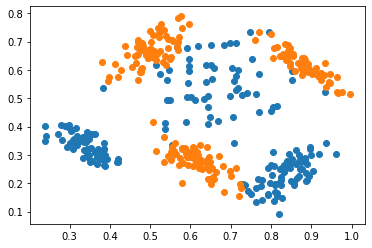

In [ ]:
import time
from IPython import display as ipythondisplay
import IPython
class DataPlotter:
  def plot(self, X_train,Y_train,wmat=None):
      labels=np.unique(Y_train)
      for j in range(labels.shape[0]):
         plt.scatter(X_train[labels[j]==Y_train,0],X_train[labels[j]==Y_train,1])

      if(wmat is not None):
        plt.scatter(winit[:,0],winit[:,1],s=150,c='#d62728')
      plt.show()
      #ipythondisplay.clear_output(wait=True)
      #ipythondisplay.display(plt.gcf())

plotter=DataPlotter();
plotter.plot(X_train,y_train)#layer.w.numpy()

(402, 2)


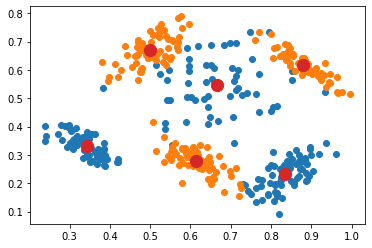


Start of epoch 0


  0%|          | 0/402 [00:00<?, ?it/s]


 test accuracy:93.43434343434343


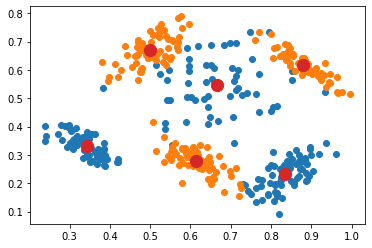


Start of epoch 1


  0%|          | 0/402 [00:00<?, ?it/s]


 test accuracy:94.94949494949495


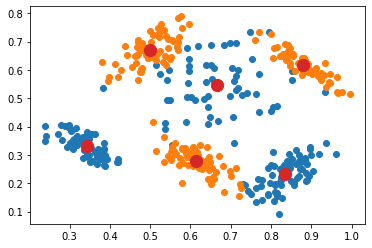


Start of epoch 2


  0%|          | 0/402 [00:00<?, ?it/s]


 test accuracy:94.94949494949495


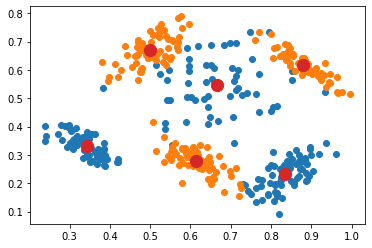


Start of epoch 3


  0%|          | 0/402 [00:00<?, ?it/s]


 test accuracy:94.94949494949495


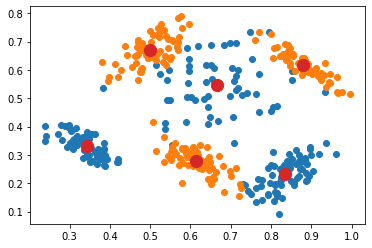


Start of epoch 4


  0%|          | 0/402 [00:00<?, ?it/s]


 test accuracy:93.93939393939394


In [ ]:
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
from tqdm.notebook import tqdm

#if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
r=2;
no_of_weights_perclss=3;
#use='gmlvq'
use='gltvq'

#############################

def NormalizeData(x,mu=None,sigma=None):
  if(mu==None):
    mu=np.mean(x,axis=0,keepdims=True);
    sigma=np.std(x,axis=0,keepdims=True);
  return (x-mu)/sigma,mu,sigma

def GetInit(X,y,r,nclasses,no_of_weights_perclss):  ##Kmeans init (GMM  might be better)
  winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1]))
  Winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1],r))
  for j in range(nclasses):
    if(no_of_weights_perclss>1):
      km=GaussianMixture(n_components=no_of_weights_perclss, random_state=0).fit(X[y==j,:])
      winit[j*no_of_weights_perclss:(j+1)*no_of_weights_perclss,:]=km.means_
      #Winit[j*no_of_weights_perclss:(j+1)*no_of_weights_perclss,:,:]=km.covariances_
      for m in range(no_of_weights_perclss):
        e,Ev=np.linalg.eigh(km.covariances_[m,:,:])
        Winit[j*no_of_weights_perclss+m,:,:]=Ev[:,-r:]
    else:
      #print(X.shape)
      winit[j,:]=np.mean(X[y==j,:],axis=0)
      covmat=np.cov(X[y==j,:],rowvar=False);
      e,Ev=np.linalg.eigh(covmat)
      #print(e)
      Winit[j,:,:]=Ev[:,-r:]
  return winit.astype('float32'),Winit.astype('float32')

optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-3);
print(X_train.shape)



X,_,_=X_train,X_train,X_train;#NormalizeData(X)
winit,Winit=GetInit(X_train,y_train,r,nclasses,no_of_weights_perclss)

## Layer definition
if(use=='gmlvq'):
  layer=GMLVQ(X.shape[1],no_of_weights_perclss,nclasses,winit=winit)  #feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer='LFT-TDS'
  epochs=5;
else:
  layer = GLTVQ(X.shape[1],r,no_of_weights_perclss,nclasses,winit=winit,Winit=Winit)
  epochs=5;


for epoch in range(epochs):
  #IPython.display.clear_output(wait=True)
  plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X_train.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer(X_train[batch_id,:],y_train[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer.Orthonormalize()

  ord=np.random.permutation(np.arange(X_train.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(X_test.shape[0])
  for batch_id in range(X_test.shape[0]):
    pred[batch_id]=layer.PointPredict(X_test[batch_id,:])
  print('\n test accuracy:'+str(np.mean(pred==y_test)*100))
  #break;
  


**train on target data**

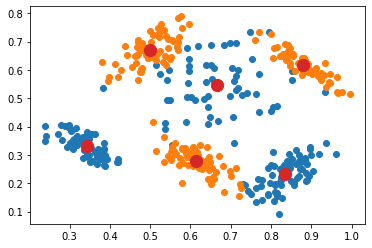


Start of epoch 0


  0%|          | 0/402 [00:00<?, ?it/s]


 test accuracy:77.77777777777779


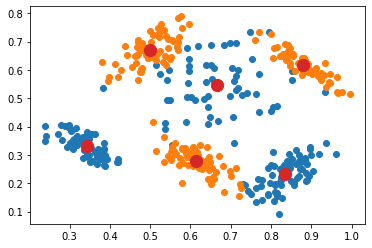


Start of epoch 1


  0%|          | 0/402 [00:00<?, ?it/s]

In [ ]:
## Layer definition
if(use=='gmlvq'):
  layer_transfer=GMLVQ(X.shape[1],no_of_weights_perclss,nclasses,winit=layer.w,do_transfer=1,type_transfer='LFT-TDS')  #feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer='LFT-TDS'
  epochs=10
else:
  layer_transfer = GLTVQ(X.shape[1],r,no_of_weights_perclss,nclasses,winit=layer.w,Winit=layer.W)
  #X_train_target=np.concatenate((X_train_target,X_train),axis=0)
  #y_train_target=np.concatenate((y_train_target,y_train),axis=0)
  epochs=10


optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-3);

for epoch in range(epochs):
  plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X_train_target.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer_transfer(X_train_target[batch_id,:],y_train_target[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer_transfer.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer_transfer.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer_transfer.Orthonormalize()

  #X_train_target=X_train_target[np.random.permutation(np.arange(X_test_target.shape[0])),:]  #Shufling for SGD 
  ####### Accuracy computation ##################
  pred=np.zeros(X_test_target.shape[0])
  for batch_id in range(X_test_target.shape[0]):
    pred[batch_id]=layer_transfer.PointPredict(X_test_target[batch_id,:].astype('float32'))
  print('\n test accuracy:'+str(np.mean(pred==y_test_target)*100))
  #break;


(3000, 28, 28) (500, 28, 28)
(3000,) (500,)


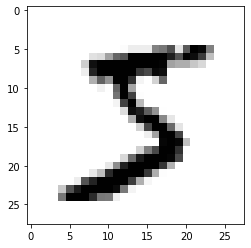

(3000, 28, 28, 1) (3000,)
Number of original training examples: 3000
Number of original test examples: 500
(3000, 784, 1) (500, 784, 1)


In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


data_slice = 3000
data_slice1 = 500
x_train = x_train[:data_slice,:]
y_train = y_train[:data_slice]
x_test = x_test[:data_slice1,:]
y_test = y_test[:data_slice1]

print(x_train.shape,x_test.shape)
print(y_train.shape,y_test.shape)
plt.imshow(x_train[0],cmap=plt.cm.binary)
plt.show()

#print(y_train)
# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0
print(x_train.shape,y_train.shape)
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

x_train=tf.reshape(x_train,(x_train.shape[0],-1,1))
x_test=tf.reshape(x_test,(x_test.shape[0],-1,1))
print(x_train.shape,x_test.shape)


#sel_inds=np.random.randint(60000,size=(1000));  ## Select 2000 train images at random 
X=x_train.numpy()[:data_slice,:]
#print(X)
labels=y_train[:data_slice]

#sel_inds=np.random.randint(10000,size=(2000));  ## Select 500 test images at random 
x_test=x_test.numpy()[:data_slice1,:]
y_test=y_test[:data_slice1]
#print(y_test)
r=7;
nclasses=10


**Train on MNIST dataset**

In [ ]:
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
#from tqdm.notebook import tqdm
#from numpy.random import multivariate_normal
#from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split

#if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
#r=7;
no_of_weights_perclss=3;
use='gmlvq'
#use='gltvq'
#############################

def NormalizeData(x,mu=None,sigma=None):
  if(mu==None):
    mu=np.mean(x,axis=0,keepdims=True);
    sigma=np.std(x,axis=0,keepdims=True);
  return (x-mu)/sigma,mu,sigma

def GetInit(X,y,r,nclasses,no_of_weights_perclss):  ##Kmeans init (GMM  might be better)
  winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1]))
  Winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1],r))
  for j in range(nclasses):
    if(no_of_weights_perclss>1):
      pass;
    else:
      #print(X.shape)
      winit[j,:]=np.mean(X[y==j,:,0],axis=0)
      covmat=np.cov(X[y==j,:,0],rowvar=False);
      e,Ev=np.linalg.eigh(covmat)
      #print(e)
      Winit[j,:,:]=Ev[:,-r:]
  return winit.astype('float32'),Winit.astype('float32')

optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-2);
print(X.shape)



X,_,_=X,X,X;#NormalizeData(X)
winit,Winit=GetInit(X,y_train,r,nclasses,no_of_weights_perclss)

## Layer definition
if(use=='gmlvq'):
  layer=GMLVQ(X.shape[1],no_of_weights_perclss,nclasses,winit=winit)  #feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer='LFT-TDS'
  epochs=5;
else:
  layer = GLTVQ(X.shape[1],r,no_of_weights_perclss,nclasses,winit=winit,Winit=Winit)
  epochs=5;



  

(3000, 784, 1)


In [ ]:
for epoch in range(epochs):
  #IPython.display.clear_output(wait=True)
  #plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer(X[batch_id,:,0],y_train[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer.Orthonormalize()

  ord=np.random.permutation(np.arange(X.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(x_test.shape[0])
  for batch_id in range(x_test.shape[0]):
    pred[batch_id]=layer.PointPredict(x_test[batch_id,:,0])
  print('\n test accuracy:'+str(np.mean(pred==y_test)*100))
  #break;

  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]


Start of epoch 0


  0%|▏                                                                                | 9/3000 [00:00<00:36, 81.14it/s]


 test accuracy:69.19999999999999

Start of epoch 1


  1%|▌                                                                               | 20/3000 [00:00<00:31, 94.31it/s]


 test accuracy:70.19999999999999

Start of epoch 2


  0%|▎                                                                               | 10/3000 [00:00<00:31, 96.23it/s]


 test accuracy:70.6

Start of epoch 3


  0%|▎                                                                               | 10/3000 [00:00<00:31, 96.21it/s]


 test accuracy:71.8

Start of epoch 4


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:32<00:00, 93.23it/s]



 test accuracy:72.8


In [ ]:
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
#from tqdm.notebook import tqdm
#from numpy.random import multivariate_normal
#from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split

#if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
#r=7;
no_of_weights_perclss=3;
#use='gmlvq'
use='gltvq'
#############################

def NormalizeData(x,mu=None,sigma=None):
  if(mu==None):
    mu=np.mean(x,axis=0,keepdims=True);
    sigma=np.std(x,axis=0,keepdims=True);
  return (x-mu)/sigma,mu,sigma

def GetInit(X,y,r,nclasses,no_of_weights_perclss):  ##Kmeans init (GMM  might be better)
  winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1]))
  Winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1],r))
  for j in range(nclasses):
    if(no_of_weights_perclss>1):
      pass;
    else:
      #print(X.shape)
      winit[j,:]=np.mean(X[y==j,:,0],axis=0)
      covmat=np.cov(X[y==j,:,0],rowvar=False);
      e,Ev=np.linalg.eigh(covmat)
      #print(e)
      Winit[j,:,:]=Ev[:,-r:]
  return winit.astype('float32'),Winit.astype('float32')

optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-2);
print(X.shape)



X,_,_=X,X,X;#NormalizeData(X)
winit,Winit=GetInit(X,y_train,r,nclasses,no_of_weights_perclss)

## Layer definition
if(use=='gmlvq'):
  layer=GMLVQ(X.shape[1],no_of_weights_perclss,nclasses,winit=winit)  #feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer='LFT-TDS'
  epochs=5;
else:
  
  layer = GLTVQ(X.shape[1],r,no_of_weights_perclss,nclasses,winit=winit)
  epochs=5;



  

(3000, 784, 1)


In [ ]:
for epoch in range(epochs):
  #IPython.display.clear_output(wait=True)
  #plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer(X[batch_id,:,0],y_train[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer.Orthonormalize()

  ord=np.random.permutation(np.arange(X.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(x_test.shape[0])
  for batch_id in range(x_test.shape[0]):
    pred[batch_id]=layer.PointPredict(x_test[batch_id,:,0])
  print('\n test accuracy:'+str(np.mean(pred==y_test)*100))
  #break;

  0%|                                                                                         | 0/3000 [00:00<?, ?it/s]


Start of epoch 0


  0%|                                                                                 | 2/3000 [00:00<03:14, 15.39it/s]


 test accuracy:37.8

Start of epoch 1


  0%|                                                                                 | 2/3000 [00:00<03:02, 16.40it/s]


 test accuracy:44.2

Start of epoch 2


  0%|                                                                                 | 2/3000 [00:00<02:53, 17.25it/s]


 test accuracy:45.4

Start of epoch 3


  0%|                                                                                 | 2/3000 [00:00<02:56, 16.96it/s]


 test accuracy:47.199999999999996

Start of epoch 4


100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [03:07<00:00, 15.98it/s]



 test accuracy:47.599999999999994


## Source data. 0, 1 ,2 

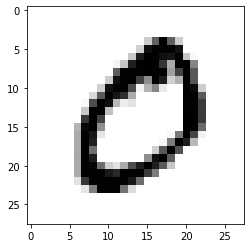

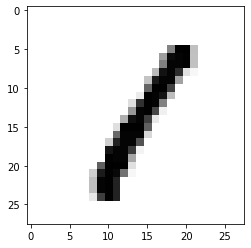

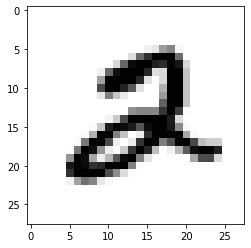

(18623, 28, 28, 1) (18623,)
Number of  training : 18623
Number of l test : 3147
(18623, 784, 1) (3147, 784, 1)


In [ ]:

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


train_filter = np.where((y_train == 0 ) | (y_train == 1) | (y_train == 2))



x_train_p = x_train[train_filter,:,:]
x_train_p =x_train_p[0]
y_train_p = y_train[train_filter]

test_filter = np.where((y_test ==0) | (y_test ==1) | ( y_test ==2) )
x_test_p = x_test[test_filter,:,:]
x_test_p = x_test_p[0]
y_test_p = y_test[test_filter]

plt.imshow(x_train_p[0], cmap=plt.cm.binary)

plt.show()
plt.imshow(x_train_p[1], cmap=plt.cm.binary)

plt.show()
plt.imshow(x_train_p[2], cmap=plt.cm.binary)

plt.show()


# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_p, x_test_p = x_train_p[..., np.newaxis]/255.0, x_test_p[..., np.newaxis]/255.0
print(x_train_p.shape,y_train_p.shape)
print("Number of  training :", len(x_train_p))
print("Number of l test :", len(x_test_p))

x_train_p=tf.reshape(x_train_p,(x_train_p.shape[0],-1,1))
x_test_p=tf.reshape(x_test_p,(x_test_p.shape[0],-1,1))
print(x_train_p.shape,x_test_p.shape)


X_p=x_train_p.numpy()
#print(X)
labels_p=y_train_p

x_test_p=x_test_p.numpy()
y_test_p=y_test_p
#print(y_test)
r=7;
nclasses=10









## Target data 3, 4 ,5

In [ ]:
from scipy import ndimage

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()


train_filter = np.where((y_train == 3 ) | (y_train == 4) | (y_train == 5))



x_train_t = x_train[train_filter,:,:]
x_train_t =x_train_t[0]
y_train_t = y_train[train_filter]

test_filter = np.where((y_test ==3) | (y_test ==4) | ( y_test ==5) )
x_test_t = x_test[test_filter,:,:]
x_test_t = x_test_t[0]
y_test_t = y_test[test_filter]

bg_value = -0.5 # this is regarded as background's value black
x_train_rot = []

for i in range(x_train_t.shape[0]):
    image = np.reshape(x_train_t[i,:,:], (-1, 28))
    
    # rotate the image with random degree
    angle = np.random.randint(-40,40,1)
    
    new_img = ndimage.rotate(image, angle[0],reshape=False, cval=bg_value)
    x_train_rot.append(new_img)

x_test_rot = []

for i in range(x_test_t.shape[0]):
    
    image = np.reshape(x_test_t[i,:,:], (-1, 28))
    # rotate the image with random degree
    angle = np.random.randint(-50,50,1)
    new_img = ndimage.rotate(image,angle[0],reshape=False, cval=bg_value)
    x_test_rot.append(new_img)
    
x_train_rot = np.array(x_train_rot)
x_test_rot = np.array(x_test_rot)

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train_t, x_test_t = x_train_rot[..., np.newaxis]/255.0, x_test_rot[..., np.newaxis]/255.0
print(x_train_t.shape,y_train_t.shape)
print("Number of  training :", len(x_train_t))
print("Number of l test :", len(x_test_t))

x_train_t=tf.reshape(x_train_t,(x_train_t.shape[0],-1,1))
x_test_t=tf.reshape(x_test_t,(x_test_t.shape[0],-1,1))
print(x_train_t.shape,x_test_t.shape)


X_t=x_train_t.numpy()
#print(X)
labels_t=y_train_t

x_test_t=x_test_t.numpy()
y_test_t=y_test_t
#print(y_test)
r=7;
nclasses=10

           


(17394, 28, 28, 1) (17394,)
Number of  training : 17394
Number of l test : 2884
(17394, 784, 1) (2884, 784, 1)


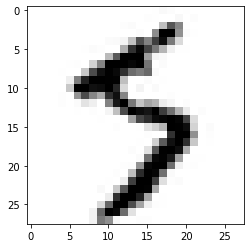

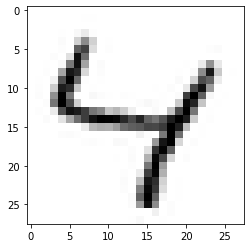

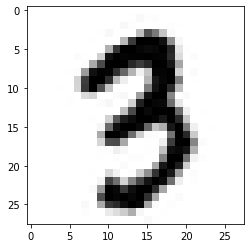

In [ ]:
plt.imshow(x_train_rot[0], cmap=plt.cm.binary)
plt.show()

plt.imshow(x_train_rot[1], cmap=plt.cm.binary)
plt.show()

plt.imshow(x_train_rot[2], cmap=plt.cm.binary)
plt.show()


In [ ]:
x_test_t.shape


(2884, 784, 1)

In [ ]:
x_train_t.shape

TensorShape([17394, 784, 1])

## gmlvq

In [ ]:

import time
from tqdm import tqdm
from sklearn.cluster import KMeans
#from tqdm.notebook import tqdm
#from numpy.random import multivariate_normal
#from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split

#if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
#r=7;
no_of_weights_perclss=3;
use='gmlvq'
#use='gltvq'
#############################

def NormalizeData(x,mu=None,sigma=None):
  if(mu==None):
    mu=np.mean(x,axis=0,keepdims=True);
    sigma=np.std(x,axis=0,keepdims=True);
  return (x-mu)/sigma,mu,sigma

def GetInit(X,y,r,nclasses,no_of_weights_perclss):  ##Kmeans init (GMM  might be better)
  winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1]))
  Winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1],r))
  for j in range(nclasses):
    if(no_of_weights_perclss>1):
      pass;
    else:
      #print(X.shape)
      winit[j,:]=np.mean(X[y==j,:,0],axis=0)
      covmat=np.cov(X[y==j,:,0],rowvar=False);
      e,Ev=np.linalg.eigh(covmat)
      #print(e)
      Winit[j,:,:]=Ev[:,-r:]
  return winit.astype('float32'),Winit.astype('float32')

optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-2);
print(X_p.shape)



X_p,_,_=X_p,X_p,X_p;#NormalizeData(X)
winit,Winit=GetInit(X_p,y_train_p,r,nclasses,no_of_weights_perclss)

## Layer definition
if(use=='gmlvq'):
  layer_m=GMLVQ(X_p.shape[1],no_of_weights_perclss,nclasses,winit=winit)  #feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer='LFT-TDS'
  epochs=5;
else:
  layer_t = GLTVQ(X_p.shape[1],r,no_of_weights_perclss,nclasses,winit=winit,Winit=Winit)
  epochs=5;



(18623, 784, 1)


In [ ]:
for epoch in range(epochs):

  #IPython.display.clear_output(wait=True)
  #plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X_p.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer_m(X_p[batch_id,:,0],y_train_p[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer_m.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer_m.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer_m.Orthonormalize()

  ord=np.random.permutation(np.arange(X_p.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(x_test_p.shape[0])
  for batch_id in range(x_test_p.shape[0]):
    pred[batch_id]=layer_m.PointPredict(x_test_p[batch_id,:,0])
  print('\n test accuracy:'+str(np.mean(pred==y_test_p)*100))
  #break;

  0%|                                                                                | 8/18623 [00:00<04:13, 73.39it/s]


Start of epoch 0


  0%|                                                                                | 9/18623 [00:00<03:39, 84.94it/s]


 test accuracy:96.05973943438195

Start of epoch 1


  0%|                                                                                | 9/18623 [00:00<03:32, 87.44it/s]


 test accuracy:97.14013346043852

Start of epoch 2


  0%|                                                                               | 10/18623 [00:00<03:17, 94.38it/s]


 test accuracy:97.29901493485859

Start of epoch 3


  0%|                                                                                | 9/18623 [00:00<03:30, 88.27it/s]


 test accuracy:97.55322529393072

Start of epoch 4


100%|████████████████████████████████████████████████████████████████████████████| 18623/18623 [03:23<00:00, 91.49it/s]



 test accuracy:97.55322529393072


## transfer learning for gmlvq

In [ ]:
use='gmlvq'
for epoch in range(epochs):

  #IPython.display.clear_output(wait=True)
  #plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
 
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X_t.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer_m(X_t[batch_id,:,0],y_train_t[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer_m.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer_m.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer_m.Orthonormalize()

  ord=np.random.permutation(np.arange(X_t.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(x_test_t.shape[0])
  for batch_id in range(x_test_t.shape[0]):
    pred[batch_id]=layer_m.PointPredict(x_test_t[batch_id,:,0])
  print('\n test accuracy:'+str(np.mean(pred==y_test_t)*100))
  #break;

  0%|                                                                               | 10/17394 [00:00<03:07, 92.62it/s]


Start of epoch 0


  0%|                                                                               | 10/17394 [00:00<03:09, 91.78it/s]


 test accuracy:79.09153952843273

Start of epoch 1


  0%|                                                                                | 9/17394 [00:00<03:17, 87.85it/s]


 test accuracy:82.97503467406379

Start of epoch 2


  0%|                                                                                | 9/17394 [00:00<03:16, 88.27it/s]


 test accuracy:84.74341192787794

Start of epoch 3


  0%|                                                                               | 10/17394 [00:00<03:19, 86.99it/s]


 test accuracy:85.64493758668516

Start of epoch 4


100%|████████████████████████████████████████████████████████████████████████████| 17394/17394 [03:05<00:00, 93.66it/s]



 test accuracy:86.3384188626907


## gltvq

In [ ]:
import time
from tqdm import tqdm
from sklearn.cluster import KMeans
#from tqdm.notebook import tqdm
#from numpy.random import multivariate_normal
#from sklearn.mixture import GaussianMixture
#from sklearn.model_selection import train_test_split

#if hasattr(tqdm, '_instances'): tqdm._instances.clear() # clear if it exists
#r=7;
no_of_weights_perclss=3;
#use='gmlvq'
use='gltvq'
#############################

def NormalizeData(x,mu=None,sigma=None):
  if(mu==None):
    mu=np.mean(x,axis=0,keepdims=True);
    sigma=np.std(x,axis=0,keepdims=True);
  return (x-mu)/sigma,mu,sigma

def GetInit(X,y,r,nclasses,no_of_weights_perclss):  ##Kmeans init (GMM  might be better)
  winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1]))
  Winit=np.zeros((nclasses*no_of_weights_perclss,X.shape[1],r))
  for j in range(nclasses):
    if(no_of_weights_perclss>1):
      pass;
    else:
      #print(X.shape)
      winit[j,:]=np.mean(X[y==j,:,0],axis=0)
      covmat=np.cov(X[y==j,:,0],rowvar=False);
      e,Ev=np.linalg.eigh(covmat)
      #print(e)
      Winit[j,:,:]=Ev[:,-r:]
  return winit.astype('float32'),Winit.astype('float32')

optimizer=tf.compat.v1.train.GradientDescentOptimizer(learning_rate=1e-2);
print(X_p.shape)



X_p,_,_=X_p,X_p,X_p;#NormalizeData(X)
winit,Winit=GetInit(X_p,y_train_p,r,nclasses,no_of_weights_perclss)

## Layer definition
if(use=='gmlvq'):
  layer_m=GMLVQ(X_p.shape[1],no_of_weights_perclss,nclasses,winit=winit)  #feat_dim,no_of_wts_per_class,num_classes,do_transfer=0,winit=None,type_transfer='LFT-TDS'
  epochs=5;
else:
  
  layer_t = GLTVQ(X_p.shape[1],r,no_of_weights_perclss,nclasses,winit=winit)
  epochs=5;



(18623, 784, 1)


In [ ]:
for epoch in range(epochs):
  #IPython.display.clear_output(wait=True)
  #plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X_p.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer_t(X_p[batch_id,:,0],y_train_p[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer_t.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer_t.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer_t.Orthonormalize()

  ord=np.random.permutation(np.arange(X_p.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(x_test_p.shape[0])
  for batch_id in range(x_test_p.shape[0]):
    pred[batch_id]=layer_t.PointPredict(x_test_p[batch_id,:,0])
  print('\n test accuracy:'+str(np.mean(pred==y_test_p)*100))
  #break;

  0%|                                                                                | 2/18623 [00:00<20:13, 15.35it/s]


Start of epoch 0


  0%|                                                                                | 2/18623 [00:00<19:04, 16.28it/s]


 test accuracy:88.17921830314586

Start of epoch 1


  0%|                                                                                | 2/18623 [00:00<20:56, 14.82it/s]


 test accuracy:88.30632348268192

Start of epoch 2


  0%|                                                                                | 2/18623 [00:00<18:18, 16.96it/s]


 test accuracy:88.43342866221798

Start of epoch 3


  0%|                                                                                | 2/18623 [00:00<20:18, 15.28it/s]


 test accuracy:88.465204957102

Start of epoch 4


100%|████████████████████████████████████████████████████████████████████████████| 18623/18623 [19:44<00:00, 15.72it/s]



 test accuracy:88.30632348268192


## transfer learning of gltvq

In [ ]:
for epoch in range(epochs):
  #IPython.display.clear_output(wait=True)
  #plotter.plot(X_train,y_train,layer.w.numpy())
  print("\nStart of epoch %d" % (epoch,))
  start_time = time.time()
  accuracy=0.0;
  ############# Iterate over the batches of the dataset ###########
  for batch_id in tqdm(range(X_t.shape[0]), position=0, leave=True):
    with tf.GradientTape() as tape:
        loss= layer_t(X_t[batch_id,:,0],y_train_t[batch_id])   ## Compute forward pass

    grads = tape.gradient(loss, layer_t.trainable_variables)     ## Compute weight gradient
    optimizer.apply_gradients(zip(grads, layer_t.trainable_variables))  ## update weights
    if(use=='gltvq'):
      layer_t.Orthonormalize()

  ord=np.random.permutation(np.arange(X_t.shape[0]))
  #X=X[ord,:]  #Shufling for SGD 
  #labels=labels[ord]
  ####### Accuracy computation ##################
  pred=np.zeros(x_test_t.shape[0])
  for batch_id in range(x_test_t.shape[0]):
    pred[batch_id]=layer_t.PointPredict(x_test_t[batch_id,:,0])
  print('\n test accuracy:'+str(np.mean(pred==y_test_t)*100))
  #break;

  0%|                                                                                        | 0/17394 [00:00<?, ?it/s]


Start of epoch 0


  0%|                                                                                | 2/17394 [00:00<19:16, 15.04it/s]


 test accuracy:62.066574202496525

Start of epoch 1


  0%|                                                                                | 2/17394 [00:00<18:50, 15.38it/s]


 test accuracy:63.45353675450763

Start of epoch 2


  0%|                                                                                | 2/17394 [00:00<16:56, 17.10it/s]


 test accuracy:64.70180305131763

Start of epoch 3


  0%|                                                                                | 2/17394 [00:00<17:40, 16.40it/s]


 test accuracy:67.37170596393898

Start of epoch 4


100%|████████████████████████████████████████████████████████████████████████████| 17394/17394 [19:20<00:00, 14.99it/s]



 test accuracy:67.40638002773926
